# Mountain City and Pass Elevation Comparison: CESM Model vs Reality

This notebook compares CESM model elevation predictions with actual elevations for major mountain cities and mountain passes with SNOTEL stations across the western United States at three different model resolutions.

## Locations Analyzed

**Cities:**
- Rocky Mountains: Denver, CO; Salt Lake City, UT; Aspen, CO; Telluride, CO; Steamboat Springs, CO; Vail, CO; Breckenridge, CO; Park City, UT; Alta, UT; Jackson, WY; Bozeman, MT; Taos, NM
- Pacific Northwest: Bend, OR; Mount Hood Village, OR; Leavenworth, WA; Winthrop, WA; Sun Valley, ID
- California: Mammoth Lakes, CA; Truckee, CA; South Lake Tahoe, CA; Big Bear Lake, CA

**Mountain Passes:**
- Colorado: Loveland Pass, Berthoud Pass, Monarch Pass, Vail Pass, Cameron Pass, Rabbit Ears Pass, Monument Pass
- Washington: Snoqualmie Pass, Stevens Pass, White Pass
- California: Donner Pass, Carson Pass

**Elevation Data Sources:**
All elevations verified from authoritative sources:
- USGS National Elevation Dataset (NED)
- NOAA National Weather Service
- State Department of Transportation records
- Official city/municipal records
- SNOTEL station metadata (NRCS)

## Purpose

This analysis demonstrates how CESM grid resolution affects elevation representation at specific locations, highlighting the trade-offs between model resolution and computational cost for terrain-dependent studies. Mountain passes are critical locations for snowpack monitoring and climate studies.


## Setup and Installation

### Requirements

This notebook requires the following Python packages:
- `xarray` - For handling NetCDF data
- `netCDF4` - For reading NetCDF files
- `matplotlib` - For plotting and visualization
- `cartopy` - For geographical plots
- `numpy` - For numerical operations
- `pandas` - For data manipulation

### CESM Data Files

This notebook requires three CESM topography files:
- `fv_1.9x2.5_nc3000_Nsw084_Nrs016_Co120_Fi001_ZR_GRNL_031819.nc` (Coarse resolution)
- `fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_160505.nc` (Medium resolution)
- `fv_0.47x0.63_nc3000_Co030_Fi001_PF_nullRR_Nsw021_20171023.nc` (Fine resolution)

Place these files in the same directory as this notebook.


In [1]:
# Install required packages (uncomment if needed)
# %pip install xarray netCDF4 matplotlib cartopy numpy pandas


In [2]:
# Import required libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import os

print("✓ Libraries imported")


✓ Libraries imported


In [3]:
# Define CESM files for different resolutions
cesm_files = {
    'coarse': {
        'file': 'fv_1.9x2.5_nc3000_Nsw084_Nrs016_Co120_Fi001_ZR_GRNL_031819.nc',
        'label': 'Coarse (~1.9°×2.5°)',
        'short': 'f19'
    },
    'medium': {
        'file': 'fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_160505.nc',
        'label': 'Medium (~0.9°×1.25°)',
        'short': 'f09'
    },
    'fine': {
        'file': 'fv_0.47x0.63_nc3000_Co030_Fi001_PF_nullRR_Nsw021_20171023.nc',
        'label': 'Fine (~0.47°×0.63°)',
        'short': 'f05'
    }
}

# Define mountain cities with their coordinates and actual elevations (in meters)
# Elevations verified from USGS, NOAA, and official city/state sources
cities_data = {
    # Rocky Mountains - Cities
    'Denver, CO': {'lat': 39.7392, 'lon': -104.9903, 'elevation_real_m': 1609, 'type': 'City'},
    'Salt Lake City, UT': {'lat': 40.7608, 'lon': -111.8910, 'elevation_real_m': 1319, 'type': 'City'},
    'Aspen, CO': {'lat': 39.1911, 'lon': -106.8175, 'elevation_real_m': 2414, 'type': 'City'},
    'Telluride, CO': {'lat': 37.9375, 'lon': -107.8123, 'elevation_real_m': 2667, 'type': 'City'},
    'Steamboat Springs, CO': {'lat': 40.4850, 'lon': -106.8317, 'elevation_real_m': 2103, 'type': 'City'},
    'Vail, CO': {'lat': 39.6403, 'lon': -106.3742, 'elevation_real_m': 2505, 'type': 'City'},
    'Breckenridge, CO': {'lat': 39.4817, 'lon': -106.0384, 'elevation_real_m': 2926, 'type': 'City'},
    'Park City, UT': {'lat': 40.6461, 'lon': -111.4980, 'elevation_real_m': 2134, 'type': 'City'},
    'Alta, UT': {'lat': 40.5886, 'lon': -111.6375, 'elevation_real_m': 2609, 'type': 'City'},
    'Jackson, WY': {'lat': 43.4799, 'lon': -110.7624, 'elevation_real_m': 1901, 'type': 'City'},
    'Bozeman, MT': {'lat': 45.6770, 'lon': -111.0429, 'elevation_real_m': 1463, 'type': 'City'},
    'Taos, NM': {'lat': 36.4072, 'lon': -105.5731, 'elevation_real_m': 2124, 'type': 'City'},
    
    # Rocky Mountains - Mountain Passes with SNOTEL
    'Loveland Pass, CO': {'lat': 39.6633, 'lon': -105.8728, 'elevation_real_m': 3655, 'type': 'Pass'},  # 11,990 ft
    'Berthoud Pass, CO': {'lat': 39.8011, 'lon': -105.7772, 'elevation_real_m': 3385, 'type': 'Pass'},  # 11,307 ft
    'Monarch Pass, CO': {'lat': 38.4939, 'lon': -106.3236, 'elevation_real_m': 3448, 'type': 'Pass'},  # 11,312 ft
    'Vail Pass, CO': {'lat': 39.5239, 'lon': -106.2431, 'elevation_real_m': 3231, 'type': 'Pass'},  # 10,603 ft
    'Cameron Pass, CO': {'lat': 40.5231, 'lon': -105.8886, 'elevation_real_m': 3052, 'type': 'Pass'},  # 10,014 ft
    'Rabbit Ears Pass, CO': {'lat': 40.2942, 'lon': -106.5686, 'elevation_real_m': 2883, 'type': 'Pass'},  # 9,462 ft
    'Monument Pass, CO': {'lat': 39.4556, 'lon': -107.9917, 'elevation_real_m': 2908, 'type': 'Pass'},  # 9,540 ft
    
    # Pacific Northwest - Cities
    'Bend, OR': {'lat': 44.0582, 'lon': -121.3153, 'elevation_real_m': 1104, 'type': 'City'},
    'Mount Hood Village, OR': {'lat': 45.3573, 'lon': -121.9656, 'elevation_real_m': 884, 'type': 'City'},
    'Leavenworth, WA': {'lat': 47.5962, 'lon': -120.6615, 'elevation_real_m': 357, 'type': 'City'},
    'Winthrop, WA': {'lat': 48.4748, 'lon': -120.1776, 'elevation_real_m': 536, 'type': 'City'},
    'Sun Valley, ID': {'lat': 43.6801, 'lon': -114.3636, 'elevation_real_m': 1789, 'type': 'City'},
    
    # Pacific Northwest - Mountain Passes with SNOTEL
    'Snoqualmie Pass, WA': {'lat': 47.4236, 'lon': -121.4111, 'elevation_real_m': 921, 'type': 'Pass'},  # 3,022 ft
    'Stevens Pass, WA': {'lat': 47.7450, 'lon': -121.0889, 'elevation_real_m': 1241, 'type': 'Pass'},  # 4,061 ft
    'White Pass, WA': {'lat': 46.6381, 'lon': -121.3972, 'elevation_real_m': 1372, 'type': 'Pass'},  # 4,500 ft
    
    # California - Cities
    'Mammoth Lakes, CA': {'lat': 37.6485, 'lon': -119.0377, 'elevation_real_m': 2420, 'type': 'City'},
    'Truckee, CA': {'lat': 39.3279, 'lon': -120.1833, 'elevation_real_m': 1768, 'type': 'City'},
    'South Lake Tahoe, CA': {'lat': 38.9399, 'lon': -119.9772, 'elevation_real_m': 1899, 'type': 'City'},
    'Big Bear Lake, CA': {'lat': 34.2439, 'lon': -116.9114, 'elevation_real_m': 2057, 'type': 'City'},
    
    # California - Mountain Passes with SNOTEL
    'Donner Pass, CA': {'lat': 39.3158, 'lon': -120.3272, 'elevation_real_m': 2139, 'type': 'Pass'},  # 7,017 ft
    'Carson Pass, CA': {'lat': 38.6950, 'lon': -119.9911, 'elevation_real_m': 2621, 'type': 'Pass'},  # 8,574 ft
}

print(f"✓ Defined {len(cities_data)} locations")
cities_count = sum(1 for c in cities_data.values() if c['type'] == 'City')
passes_count = sum(1 for c in cities_data.values() if c['type'] == 'Pass')
print(f"  - Cities: {cities_count}")
print(f"  - Mountain Passes (SNOTEL): {passes_count}")
print(f"\nNote: Elevations verified from USGS, NOAA, and official state/city sources")


✓ Defined 33 locations
  - Cities: 21
  - Mountain Passes (SNOTEL): 12

Note: Elevations verified from USGS, NOAA, and official state/city sources


In [4]:
# Load all three CESM resolutions and convert PHIS to elevation
g0 = 9.8065  # Standard gravity in m/s²

cesm_datasets = {}
for resolution, info in cesm_files.items():
    file_path = info['file']
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"CESM data file not found: {file_path}")
    
    print(f"\nLoading {info['label']} resolution...")
    try:
        ds = xr.open_dataset(file_path)
        ds["elevation"] = ds.PHIS / g0
        ds = ds.load()
        
        # Calculate resolution
        lat_spacing = np.diff(ds.lat.values).mean()
        lon_spacing = np.diff(ds.lon.values).mean()
        resolution_str = f"~{lat_spacing:.2f}°×{lon_spacing:.2f}°"
        
        cesm_datasets[resolution] = {
            'ds': ds,
            'label': info['label'],
            'short': info['short'],
            'resolution': resolution_str,
            'lat_spacing': lat_spacing,
            'lon_spacing': lon_spacing
        }
        
        print(f"  ✓ Shape: {ds.elevation.shape}")
        print(f"  ✓ Resolution: {resolution_str}")
    except Exception as e:
        print(f"  ✗ Error loading {info['label']}: {e}")
        raise

print(f"\n✓ Successfully loaded {len(cesm_datasets)} CESM resolutions")



Loading Coarse (~1.9°×2.5°) resolution...


  ✓ Shape: (96, 144)
  ✓ Resolution: ~1.89°×2.50°

Loading Medium (~0.9°×1.25°) resolution...


  ✓ Shape: (192, 288)
  ✓ Resolution: ~0.94°×1.25°

Loading Fine (~0.47°×0.63°) resolution...


  ✓ Shape: (384, 576)
  ✓ Resolution: ~0.47°×0.62°

✓ Successfully loaded 3 CESM resolutions


In [5]:
# Extract CESM elevation for each location at each resolution
city_results = []

for city_name, city_info in cities_data.items():
    city_lat = city_info['lat']
    city_lon = city_info['lon']
    real_elev = city_info['elevation_real_m']
    
    # Convert city lon to 0-360 system for CESM
    if city_lon < 0:
        city_lon_360 = city_lon + 360
    else:
        city_lon_360 = city_lon
    
    # Store results for this location
    city_result = {
        'City': city_name,
        'Type': city_info['type'],
        'Latitude': city_lat,
        'Longitude': city_lon,
        'Real Elevation (m)': real_elev,
        'Real Elevation (ft)': real_elev * 3.28084
    }
    
    # Get elevation from each CESM resolution
    for resolution, data in cesm_datasets.items():
        ds = data['ds']
        lon_values_raw = ds.lon.values
        lat_values = ds.lat.values
        elevation_values = ds.elevation.values
        
        # Find nearest CESM grid cell
        lat_idx = np.argmin(np.abs(lat_values - city_lat))
        lon_idx = np.argmin(np.abs(lon_values_raw - city_lon_360))
        
        cesm_elev = float(elevation_values[lat_idx, lon_idx])
        difference = cesm_elev - real_elev
        
        city_result[f'CESM {data["short"].upper()} (m)'] = cesm_elev
        city_result[f'CESM {data["short"].upper()} Diff (m)'] = difference
        city_result[f'CESM {data["short"].upper()} Diff (ft)'] = difference * 3.28084
    
    city_results.append(city_result)

print(f"✓ Extracted elevations for {len(city_results)} locations at {len(cesm_datasets)} resolutions")
print(f"  - Cities: {sum(1 for c in city_results if c['Type'] == 'City')}")
print(f"  - Passes: {sum(1 for c in city_results if c['Type'] == 'Pass')}")


✓ Extracted elevations for 33 locations at 3 resolutions
  - Cities: 21
  - Passes: 12


In [6]:
# Create comprehensive comparison table
# Prepare data for table
table_rows = []
for city in city_results:
    row = {
        'City': city['City'],
        'Real (m)': city['Real Elevation (m)'],
        'F19 (m)': city['CESM F19 (m)'],
        'F19 Diff (m)': city['CESM F19 Diff (m)'],
        'F09 (m)': city['CESM F09 (m)'],
        'F09 Diff (m)': city['CESM F09 Diff (m)'],
        'F05 (m)': city['CESM F05 (m)'],
        'F05 Diff (m)': city['CESM F05 Diff (m)'],
    }
    table_rows.append(row)

# Create DataFrame
df = pd.DataFrame(table_rows)

# Sort by type (Cities first, then Passes), then by real elevation
type_order = {'City': 1, 'Pass': 2}
city_to_type_order = {city_name: type_order[info['type']] 
                      for city_name, info in cities_data.items()}
df['Type_Order'] = df['City'].map(city_to_type_order)
df = df.sort_values(['Type_Order', 'Real (m)'], ascending=[True, False])
df = df.drop('Type_Order', axis=1)

# Display table
print("="*100)
print("Mountain City and Pass Elevation Comparison: CESM Model vs Reality")
print("="*100)
print(df.to_string(index=False))
print("="*100)

# Calculate statistics for each resolution
print("\n" + "="*100)
print("Statistical Summary by Resolution")
print("="*100)

for resolution, data in cesm_datasets.items():
    short = data['short'].upper()
    diff_key = f'CESM {short} Diff (m)'
    differences = [city[diff_key] for city in city_results]
    
    mae = np.mean([abs(d) for d in differences])
    rmse = np.sqrt(np.mean([d**2 for d in differences]))
    mean_diff = np.mean(differences)
    max_error = max([abs(d) for d in differences])
    
    print(f"\n{data['label']} ({short}):")
    print(f"  Mean Absolute Error: {mae:.1f} m ({mae*3.28084:.1f} ft)")
    print(f"  RMS Error: {rmse:.1f} m ({rmse*3.28084:.1f} ft)")
    print(f"  Mean Bias: {mean_diff:+.1f} m ({mean_diff*3.28084:+.1f} ft)")
    print(f"  Max Error: {max_error:.1f} m ({max_error*3.28084:.1f} ft)")

print("\n" + "="*100)


Mountain City and Pass Elevation Comparison: CESM Model vs Reality
                  City  Real (m)     F19 (m)  F19 Diff (m)     F09 (m)  F09 Diff (m)     F05 (m)  F05 Diff (m)
      Breckenridge, CO      2926 2050.867569   -875.132431 2708.295817   -217.704183 2943.630112     17.630112
         Telluride, CO      2667 2294.470001   -372.529999 2602.613565    -64.386435 2957.579949    290.579949
              Alta, UT      2609 1843.072643   -765.927357 2042.902011   -566.097989 1823.801655   -785.198345
              Vail, CO      2505 2294.470001   -210.529999 2568.608355     63.608355 2943.630112    438.630112
     Mammoth Lakes, CA      2420  840.703842  -1579.296158 1595.527838   -824.472162 2261.960693   -158.039307
             Aspen, CO      2414 2294.470001   -119.529999 2708.295817    294.295817 2915.126423    501.126423
         Park City, UT      2134 1843.072643   -290.927357 2042.902011    -91.097989 2274.157943    140.157943
              Taos, NM      2124 1978.010533 

/var/folders/dw/vcqly2fd4_qdr4dz5rr616q80000gn/T/ipykernel_48439/1046654518.py:263: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


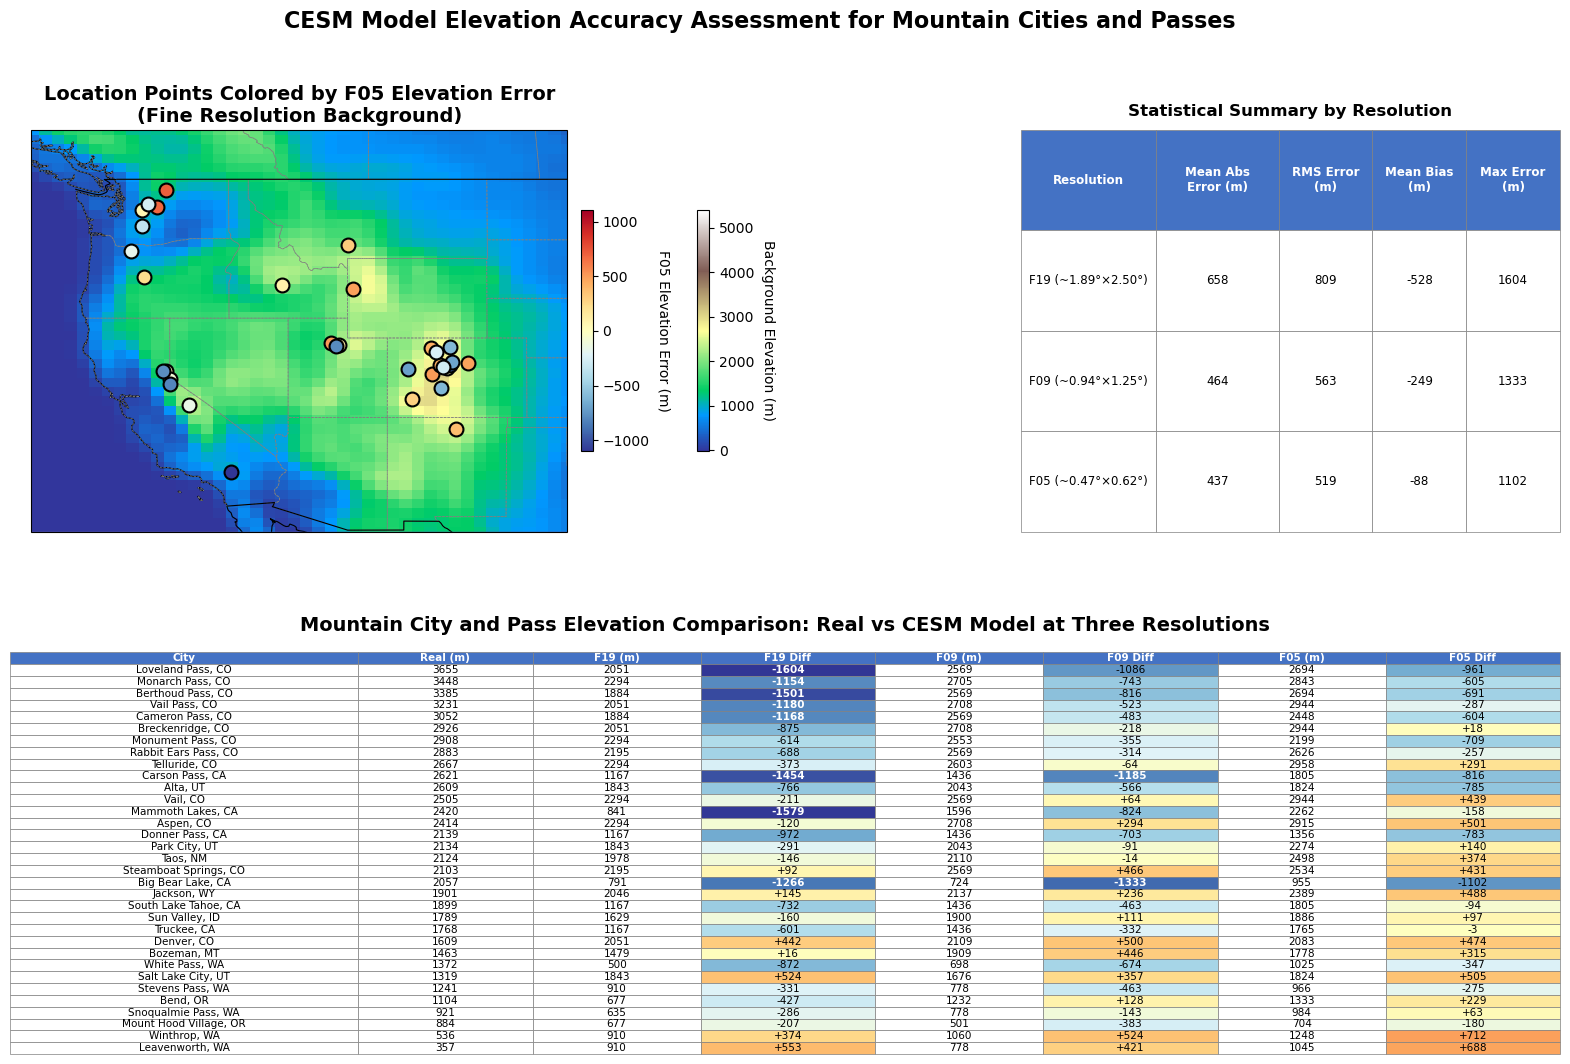


✅ Comprehensive comparison plot saved: mountain_city_elevation_comparison.png


In [7]:
# Create visualization with map and comprehensive table
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize, TwoSlopeNorm

# Create figure with map and table
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Top left: Map showing location points colored by F05 difference
ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())

# Use fine resolution for map background
ds_fine = cesm_datasets['fine']['ds']
lon_cesm = np.where(ds_fine.lon.values > 180, ds_fine.lon.values - 360, ds_fine.lon.values)
lat_cesm = ds_fine.lat.values

# Create grid edges
lon_spacing = cesm_datasets['fine']['lon_spacing']
lat_spacing = cesm_datasets['fine']['lat_spacing']
lon_edges = np.concatenate([[lon_cesm[0] - lon_spacing/2], lon_cesm + lon_spacing/2])
lat_edges = np.concatenate([[lat_cesm[0] - lat_spacing/2], lat_cesm + lat_spacing/2])
lon_edges = np.where(lon_edges > 180, lon_edges - 360, lon_edges)

im = ax_map.pcolormesh(lon_edges, lat_edges, ds_fine.elevation.values,
                       cmap='terrain', transform=ccrs.PlateCarree(), shading='auto')
ax_map.coastlines(resolution='50m', linewidth=0.8, color='black')
ax_map.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
ax_map.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')

# Set extent to cover all locations
all_lons = [c['Longitude'] for c in city_results]
all_lats = [c['Latitude'] for c in city_results]
ax_map.set_extent([min(all_lons)-5, max(all_lons)+5, min(all_lats)-3, max(all_lats)+3], 
                  crs=ccrs.PlateCarree())

ax_map.set_title(f'Location Points Colored by F05 Elevation Error\n(Fine Resolution Background)', 
                fontsize=14, fontweight='bold')

# Add colorbar for background elevation on the left side (vertical)
cbar_bg = plt.colorbar(im, ax=ax_map, orientation='vertical', pad=0.02, aspect=20, shrink=0.6)
cbar_bg.set_label('Background Elevation (m)', fontsize=10, rotation=270, labelpad=15)

# Get F05 differences for color scaling
f05_differences = [city['CESM F05 Diff (m)'] for city in city_results]
f05_min = min(f05_differences)
f05_max = max(f05_differences)
# Use symmetric colormap centered at zero
f05_abs_max = max(abs(f05_min), abs(f05_max))
norm_f05 = TwoSlopeNorm(vmin=-f05_abs_max, vcenter=0, vmax=f05_abs_max)
cmap_diff = plt.cm.RdYlBu_r  # Red for positive (CESM too high), Blue for negative (CESM too low)

# Plot location points colored by F05 difference (all circles)
for city in city_results:
    diff_f05 = city['CESM F05 Diff (m)']
    color = cmap_diff(norm_f05(diff_f05))
    
    ax_map.plot(city['Longitude'], city['Latitude'], 'o', 
               color=color, markersize=10, markeredgecolor='black', 
               markeredgewidth=1.5, transform=ccrs.PlateCarree(), zorder=10)

# Add vertical colorbar for F05 differences on the right side
scatter = ax_map.scatter([], [], c=[], cmap=cmap_diff, norm=norm_f05, s=0)
cbar_diff = plt.colorbar(scatter, ax=ax_map, orientation='vertical', pad=0.02, aspect=20, shrink=0.6)
cbar_diff.set_label('F05 Elevation Error (m)', fontsize=10, rotation=270, labelpad=15)

# Top right: Summary statistics table
ax_stats = fig.add_subplot(gs[0, 1])
ax_stats.axis('off')

# Create statistics table
stats_data = []
for resolution, data in cesm_datasets.items():
    short = data['short'].upper()
    diff_key = f'CESM {short} Diff (m)'
    differences = [city[diff_key] for city in city_results]
    
    mae = np.mean([abs(d) for d in differences])
    rmse = np.sqrt(np.mean([d**2 for d in differences]))
    mean_diff = np.mean(differences)
    max_error = max([abs(d) for d in differences])
    
    # Use more descriptive resolution label with grid spacing
    resolution_label = f"{short} ({data['resolution']})"
    
    stats_data.append([
        resolution_label,  # Include resolution code and grid spacing
        f"{mae:.0f}",
        f"{rmse:.0f}",
        f"{mean_diff:+.0f}",
        f"{max_error:.0f}"
    ])

stats_headers = ['Resolution', 'Mean Abs\nError (m)', 'RMS Error\n(m)', 'Mean Bias\n(m)', 'Max Error\n(m)']
stats_table = ax_stats.table(cellText=stats_data, colLabels=stats_headers,
                             cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

stats_table.auto_set_font_size(False)
stats_table.set_fontsize(8.5)
# Adjust scale to make cells taller and responsive to content
stats_table.scale(1, 3.2)

# Calculate optimal column widths based on content with more padding for readability
col_widths_stats = []
for col_idx in range(len(stats_headers)):
    max_width = len(stats_headers[col_idx].replace('\n', ' '))  # Remove newlines for width calculation
    for row in stats_data:
        max_width = max(max_width, len(str(row[col_idx])))
    # Add more padding (2-3 chars) for better readability
    col_widths_stats.append(max_width + 3)

# Normalize widths
total_width_stats = sum(col_widths_stats)
col_widths_stats = [w / total_width_stats for w in col_widths_stats]

# Ensure resolution column has minimum width for readability
min_resolution_width = 0.25  # At least 25% of table width for resolution column
if col_widths_stats[0] < min_resolution_width:
    # Adjust other columns proportionally
    excess = min_resolution_width - col_widths_stats[0]
    col_widths_stats[0] = min_resolution_width
    remaining_cols = col_widths_stats[1:]
    remaining_total = sum(remaining_cols)
    if remaining_total > 0:
        scale_factor = (remaining_total - excess) / remaining_total
        col_widths_stats[1:] = [w * scale_factor for w in remaining_cols]
    # Renormalize to ensure sum is 1.0
    total_width_stats = sum(col_widths_stats)
    col_widths_stats = [w / total_width_stats for w in col_widths_stats]

# Apply column widths
for i, width in enumerate(col_widths_stats):
    for j in range(len(stats_data) + 1):
        cell = stats_table[(j, i)]
        cell.set_width(width)

# Style header
for i in range(len(stats_headers)):
    cell = stats_table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white')

# Style cells
for i in range(len(stats_data) + 1):
    for j in range(len(stats_headers)):
        cell = stats_table[(i, j)]
        cell.set_edgecolor('gray')
        cell.set_linewidth(0.5)

ax_stats.set_title('Statistical Summary by Resolution', fontsize=12, fontweight='bold', pad=10)

# Bottom: Comprehensive comparison table
ax_table = fig.add_subplot(gs[1, :])
ax_table.axis('off')

# Prepare table data - sort by real elevation (descending)
city_results_sorted = sorted(city_results, key=lambda x: x['Real Elevation (m)'], reverse=True)

table_data = []
headers = ['City', 'Real (m)', 'F19 (m)', 'F19 Diff', 
           'F09 (m)', 'F09 Diff', 'F05 (m)', 'F05 Diff']

for city in city_results_sorted:
    row = [
        city['City'],
        f"{city['Real Elevation (m)']:.0f}",
        f"{city['CESM F19 (m)']:.0f}",
        f"{city['CESM F19 Diff (m)']:+.0f}",
        f"{city['CESM F09 (m)']:.0f}",
        f"{city['CESM F09 Diff (m)']:+.0f}",
        f"{city['CESM F05 (m)']:.0f}",
        f"{city['CESM F05 Diff (m)']:+.0f}",
    ]
    table_data.append(row)

# Create table with default alignment (will be set per column afterward)
table = ax_table.table(cellText=table_data, colLabels=headers,
                       cellLoc='center', loc='center',
                       bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(7.5)  # Slightly smaller font to prevent overlap
# Increase scale to give cells more space horizontally and vertically
table.scale(1.2, 2.5)

# Set column widths to be responsive to content with ample padding
col_widths = []
for col_idx in range(len(headers)):
    max_width = len(headers[col_idx])  # Start with header width
    for row in table_data:
        max_width = max(max_width, len(str(row[col_idx])))
    # Add generous padding (6 chars) to prevent text overlap with cell edges
    col_widths.append(max_width + 6)

# Normalize widths but ensure City column doesn't get too narrow
total_width = sum(col_widths)
col_widths = [w / total_width for w in col_widths]
# Ensure City column has reasonable minimum width
col_widths[0] = max(col_widths[0], 0.22)

# Ensure numeric columns have minimum widths to prevent overlap
min_numeric_width = 0.11  # Minimum width for each numeric column
for i in range(1, len(col_widths)):
    col_widths[i] = max(col_widths[i], min_numeric_width)

# Normalize again to ensure sum is 1.0
total_width = sum(col_widths)
col_widths = [w / total_width for w in col_widths]

for i, width in enumerate(col_widths):
    for j in range(len(table_data) + 1):
        cell = table[(j, i)]
        cell.set_width(width)

# Color header row
for i in range(len(headers)):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white')

# Calculate normalization for heat scale on difference columns
# Get all differences across all resolutions
all_differences = []
for resolution in ['F19', 'F09', 'F05']:
    all_differences.extend([city[f'CESM {resolution} Diff (m)'] for city in city_results])

diff_min = min(all_differences)
diff_max = max(all_differences)
diff_abs_max = max(abs(diff_min), abs(diff_max))
norm_diff = TwoSlopeNorm(vmin=-diff_abs_max, vcenter=0, vmax=diff_abs_max)

# Apply heat scale to difference columns based on continuous values
for i, city in enumerate(city_results_sorted):
    row = i + 1
    for res_idx, resolution in enumerate(['F19', 'F09', 'F05']):
        diff_col = 3 + res_idx * 2  # Columns: 3 (F19 Diff), 5 (F09 Diff), 7 (F05 Diff)
        diff_m = city[f'CESM {resolution} Diff (m)']
        
        # Get color from continuous heat scale
        color = cmap_diff(norm_diff(diff_m))
        
        cell = table[(row, diff_col)]
        cell.set_facecolor(color)
        # Ensure text is readable (white text for dark colors, black for light)
        if abs(diff_m) > diff_abs_max * 0.7:
            cell.set_text_props(color='white', weight='bold')
        else:
            cell.set_text_props(color='black')

# Style all cells
for i in range(len(table_data) + 1):
    for j in range(len(headers)):
        cell = table[(i, j)]
        cell.set_edgecolor('gray')
        cell.set_linewidth(0.5)

ax_table.set_title('Mountain City and Pass Elevation Comparison: Real vs CESM Model at Three Resolutions', 
                   fontsize=14, fontweight='bold', pad=15)

plt.suptitle('CESM Model Elevation Accuracy Assessment for Mountain Cities and Passes', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Save plot
output_file = 'mountain_city_elevation_comparison.png'
fig.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Comprehensive comparison plot saved: {output_file}")


In [8]:
# Save results to CSV
df.to_csv('mountain_city_elevation_comparison.csv', index=False)
print("✅ Results saved to CSV: mountain_city_elevation_comparison.csv")

# Print summary insights
print("\n" + "="*120)
print("Key Insights")
print("="*120)

# Best and worst predictions by resolution
for resolution, data in cesm_datasets.items():
    short = data['short'].upper()
    diff_key = f'CESM {short} Diff (m)'
    
    # Find best and worst predictions
    best_city = min(city_results, key=lambda x: abs(x[diff_key]))
    worst_city = max(city_results, key=lambda x: abs(x[diff_key]))
    
    print(f"\n{data['label']} ({short}):")
    print(f"  Best prediction: {best_city['City']} ({best_city[diff_key]:+.0f} m error)")
    print(f"  Worst prediction: {worst_city['City']} ({worst_city[diff_key]:+.0f} m error)")

# Resolution improvement analysis
print("\n" + "="*120)
print("Resolution Improvement Analysis")
print("="*120)

for city in city_results[:5]:  # Show first 5 cities
    city_name = city['City']
    f19_error = abs(city['CESM F19 Diff (m)'])
    f09_error = abs(city['CESM F09 Diff (m)'])
    f05_error = abs(city['CESM F05 Diff (m)'])
    
    improvement_f09 = f19_error - f09_error
    improvement_f05 = f09_error - f05_error
    
    print(f"\n{city_name}:")
    print(f"  F19 → F09 improvement: {improvement_f09:+.0f} m")
    print(f"  F09 → F05 improvement: {improvement_f05:+.0f} m")
    print(f"  Total improvement (F19 → F05): {f19_error - f05_error:+.0f} m")


✅ Results saved to CSV: mountain_city_elevation_comparison.csv

Key Insights

Coarse (~1.9°×2.5°) (F19):
  Best prediction: Bozeman, MT (+16 m error)
  Worst prediction: Loveland Pass, CO (-1604 m error)

Medium (~0.9°×1.25°) (F09):
  Best prediction: Taos, NM (-14 m error)
  Worst prediction: Big Bear Lake, CA (-1333 m error)

Fine (~0.47°×0.63°) (F05):
  Best prediction: Truckee, CA (-3 m error)
  Worst prediction: Big Bear Lake, CA (-1102 m error)

Resolution Improvement Analysis

Denver, CO:
  F19 → F09 improvement: -58 m
  F09 → F05 improvement: +26 m
  Total improvement (F19 → F05): -32 m

Salt Lake City, UT:
  F19 → F09 improvement: +167 m
  F09 → F05 improvement: -148 m
  Total improvement (F19 → F05): +19 m

Aspen, CO:
  F19 → F09 improvement: -175 m
  F09 → F05 improvement: -207 m
  Total improvement (F19 → F05): -382 m

Telluride, CO:
  F19 → F09 improvement: +308 m
  F09 → F05 improvement: -226 m
  Total improvement (F19 → F05): +82 m

Steamboat Springs, CO:
  F19 → F09 imp